# Satellite Image Segmentation of Nepal
**Prepared By:** Ajeeb Rimal | M. Tech. AI | Kathmandu University

## Notebook setup and imports

In [1]:
import cv2
%reload_ext autoreload
%autoreload 2

import os
import random
from rasterio.features import shapes
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from osgeo import ogr, gdal
from torchvision.transforms import transforms

from generator import NepalDataset, NepalDataGenerator
from pan import PAN
from train import train_model
from utils import create_patches, visualize

## Directory definitions
We have defined the directory paths for the dataset, image, and mask files. We have also defined and created the output directory where the patches will be saved.Additionally we have defined the patch size, stride, and boundary for the patches. The boundary is defined as a list of four values: [min_x, min_y, max_x, max_y] which represent the minimum and maximum x and y coordinates of the area of interest, respectively. We have used the `os` library to create the output directory if it does not exist.

In [2]:
dataset_dir = os.path.join('media', 'D-Drive', 'Dataset')
image_dir = os.path.join(dataset_dir, 'Butwal Orthomosaics Only')
mask_dir = os.path.join(dataset_dir, 'Butwal Shapefiles', 'Mission 1')

current_image_file_name = 'Mission 1.tif'
current_mask_file_name = 'Mission 1 Landcover.shp'

# Path to the image file in .tif format
image_path = os.path.join(image_dir, current_image_file_name)

# Path to the shape file containing the landcover classes in .shp format
mask_path = os.path.join(mask_dir,
                         current_mask_file_name)

output_dir = os.path.join('.', 'output')
os.makedirs(output_dir, exist_ok=True)

rasterized_dir = os.path.join(output_dir, 'rasterized_outputs')
os.makedirs(rasterized_dir, exist_ok=True)

rasterized_file_name = "Result.tif"
rasterized_file_path = os.path.join(rasterized_dir, rasterized_file_name)

patch_size = 512
stride = 256
boundary = [3053710.461731, 751158.377075, 3055429.699707, 753175.112122]

patch_output_dir = os.path.join(output_dir, f"{patch_size}x{patch_size}")
os.makedirs(patch_output_dir, exist_ok=True)

labels_output_dir = os.path.join(patch_output_dir, 'labels')
os.makedirs(labels_output_dir, exist_ok=True)

## Dataset preparation

### Rasterize the mask
Rasterize the mask to the same projection and pixel resolution as the reference image. We have used the `gdal` library to rasterize the mask. The `gdal` library is a translator library for raster and vector geospatial data formats. It also includes a variety of useful command-line utilities for data translation and processing.

In [12]:
mask_shape_file_path = mask_path
image_file_path = image_path

gdalformat = 'GTiff'
datatype = gdal.GDT_Float32

# Get projection info from reference image
Image = gdal.Open(image_file_path, gdal.GA_ReadOnly)

# Open Shapefile
Shapefile = ogr.Open(mask_shape_file_path)
Shapefile_layer = Shapefile.GetLayer()

# Rasterise
print("Rasterizing shapefile...")

Output = gdal.GetDriverByName(gdalformat).Create(rasterized_file_path, Image.RasterXSize, Image.RasterYSize, 1,
                                                 datatype,
                                                 options=['COMPRESS=DEFLATE'])
Output.SetProjection(Image.GetProjectionRef())
Output.SetGeoTransform(Image.GetGeoTransform())

# Write data to band 1
Band = Output.GetRasterBand(1)
Band.SetNoDataValue(0)

gdal.RasterizeLayer(Output, [1], Shapefile_layer, options=['ATTRIBUTE=Class_id'])

# Close datasets
Band = None
Output = None
Image = None
Shapefile = None

print("Rasterization of shapefile completed.")

Rasterizing shapefile...
Rasterization of shapefile completed.


### Visualize the image and its rasterized mask
We can visualize the image and the rasterized mask using the `matplotlib` library. The `matplotlib` library is a plotting library for the Python programming language and its numerical mathematics extension, NumPy. We can use the `imshow()` function from the `matplotlib.pyplot` module to display the image and the mask.

In [17]:
# Open the rasters
with rasterio.open(image_path) as raster1:
    temp_img = raster1.read()  # Read raster1 into numpy array

with rasterio.open(rasterized_file_path) as raster2:
    temp_mask = raster2.read(1)  # Read raster2 into numpy array

labels, count = np.unique(temp_mask, return_counts=True)  #Check for each channel. All channels are identical
print('Unique values in mask: ', labels)
print('Counts of unique values: ', count)

RasterioIOError: output/512x512/masks/test/patch_3281_mask.jpg: No such file or directory

In [ ]:
# The image data read by Rasterio is in (bands, rows, cols) order
# Convert the image data to (rows, cols, bands) order for visualization
transposed_image = temp_img.transpose((1, 2, 0))

# Scale the image data to be between 0 and 1 for better visualization
transposed_image -= transposed_image.min()
transposed_image /= transposed_image.max()

plt.figure(figsize=(12, 8))
# Plot raster1
plt.imshow(transposed_image, interpolation='nearest')
# Overlay raster2, make sure to use the same extent 
plt.imshow(temp_mask, interpolation='nearest', cmap='tab10', alpha=0.4)
plt.show()

print('Image shape: ', temp_img.shape)
print('Mask shape: ', temp_mask.shape)

### Create image and mask patches

To prepare the satellite images and masks for segmentation, we first need to convert them into smaller patches. Here's how we can do it:

1. Use the `create_patches()` function from the `utils` module.
2. Pass the following parameters to the function:
    - The file path of the satellite image in `.tif` format.
    - The file path of the mask in `.shp` format.
    - The output directory where the created patches will be saved.
    - The patch size (we use the same value for height and width).
    - The stride.
    - A boundary that defines the area of interest.
3. The function will iterate over the satellite image in patches of the specified size and stride.
4. For each patch, the function will check if it intersects with any mask geometries (which are shapes such as polygons, lines, points, etc. that represent the features belonging to certain classes).
5. If the patch intersects with any mask geometries, the function will create a patch mask by rasterizing the intersecting mask geometries. Otherwise, it will discard the patch.
6. The function will save the patch and its corresponding patch mask to the output directory.

In [3]:
create_patches(image_path, rasterized_file_path, patch_output_dir, patch_size, stride)

Generating patches...


0it [00:00, ?it/s]


Number of intersecting masks for patch 0: 0

Number of intersecting masks for patch 1: 0

Number of intersecting masks for patch 2: 0

Number of intersecting masks for patch 3: 0

Number of intersecting masks for patch 4: 0

Number of intersecting masks for patch 5: 0

Number of intersecting masks for patch 6: 0

Number of intersecting masks for patch 7: 0

Number of intersecting masks for patch 8: 0

Number of intersecting masks for patch 9: 0

Number of intersecting masks for patch 10: 0

Number of intersecting masks for patch 11: 0

Number of intersecting masks for patch 12: 0

Number of intersecting masks for patch 13: 0

Number of intersecting masks for patch 14: 0

Number of intersecting masks for patch 15: 0

Number of intersecting masks for patch 16: 0

Number of intersecting masks for patch 17: 0

Number of intersecting masks for patch 18: 0

Number of intersecting masks for patch 19: 0

Number of intersecting masks for patch 20: 0

Number of intersecting masks for patch 21: 

### Visualize a random image patch and its mask
We can visualize a random patch and its mask using the `rasterio` and `matplotlib` libraries. The `rasterio` library is a Python package that provides a fast and direct way to work with raster data. We can use the `rasterio.open()` function to open the image and mask files. We can then use the `read()` function to read the image and mask data. We can then use the `imshow()` function from the `matplotlib.pyplot` module to display the image and the mask.

In [ ]:
# Get list of all image files in the directory
image_files = [f for f in os.listdir(patch_output_dir + "/images") if f.endswith('.tiff')]

# Select a random image file
random_image_file = random.choice(image_files)

# Construct the full paths to the image and mask files
temp_image_path = os.path.join(patch_output_dir, "images", random_image_file)
temp_mask_path = os.path.join(patch_output_dir, "masks", random_image_file.replace('.tiff', '_mask.tiff'))

# Open the image and mask files using Rasterio
with rasterio.open(temp_image_path) as src:
    image = src.read().astype(float)
    image_transform = src.transform

with rasterio.open(temp_mask_path) as src:
    mask = src.read()
    mask_transform = src.transform

# The image data read by Rasterio is in (bands, rows, cols) order
# Convert the image data to (rows, cols, bands) order for visualization
transposed_image = image.transpose((1, 2, 0))

# Scale the image data to be between 0 and 1 for better visualization
transposed_image -= transposed_image.min()
transposed_image /= transposed_image.max()

# Create plots
fig, ax = plt.subplots(1, 2, figsize=(15, 15))

# Display the image
ax[0].imshow(transposed_image)
ax[0].set_title("Image")

# Display the mask
ax[1].imshow(mask[0], cmap='gray')
ax[1].set_title("Mask")

plt.tight_layout()
plt.show()

print('Image shape: ', image.shape)
print('Mask shape: ', mask.shape)

### Dataset and data generator

We define the dataset and data generator that will be used for training the model. To define the dataset and data generator, we can use the `NepalDataset` and `NepalDataGenerator` classes from the `dataset` module. This code takes a dataset and generates batches of data for training a deep learning model.

In [4]:
data_path = patch_output_dir
in_channels = 4
num_classes = 3
batch_size = 4
shuffle = True

transform = transforms.Compose([
    transforms.ToTensor(),
])

dataset = NepalDataset(data_path, transform=transform)
print(f"Dataset size: {format(len(dataset))}")
data_generator = NepalDataGenerator(dataset, batch_size=batch_size, shuffle=shuffle)
print(f"Data generator size: {format(len(data_generator))}")

Dataset size: 6044
Data generator size: 1511


### Visualize data generator output image and mask patches

This code visualizes the patches and patch masks that were created using the data generator. To visualize the patches and patch masks, we can use the `visualize()` function from `utils` module.

Image shape: (2048, 2048, 4)
Mask shape: (2048, 2048)


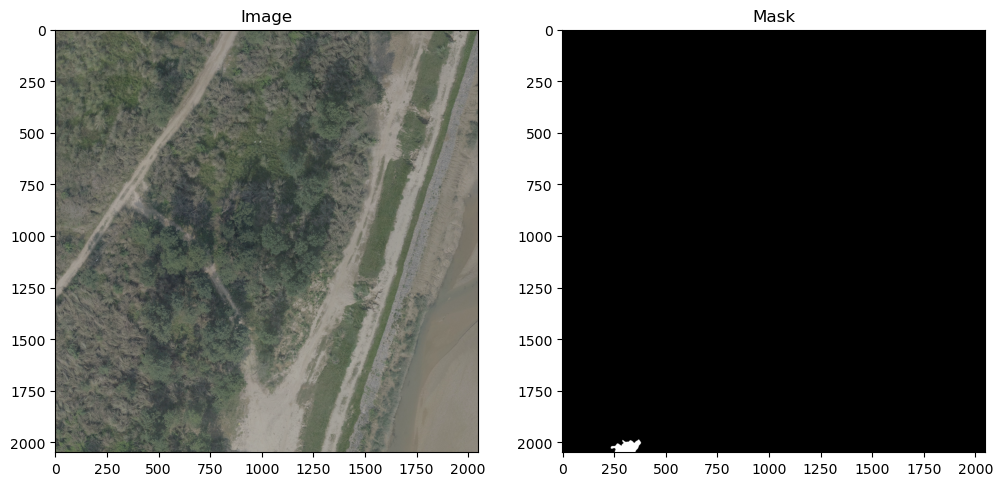

Image shape: (2048, 2048, 4)
Mask shape: (2048, 2048)


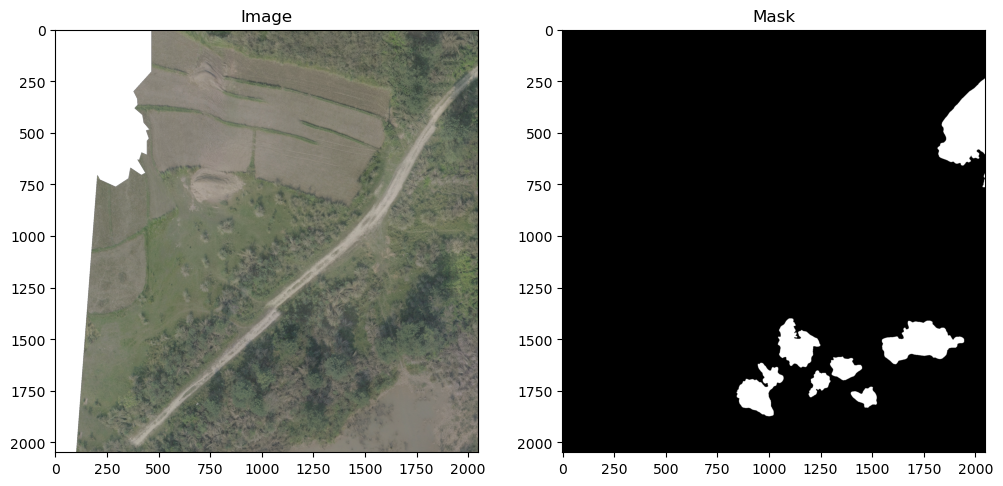

Image shape: (2048, 2048, 4)
Mask shape: (2048, 2048)


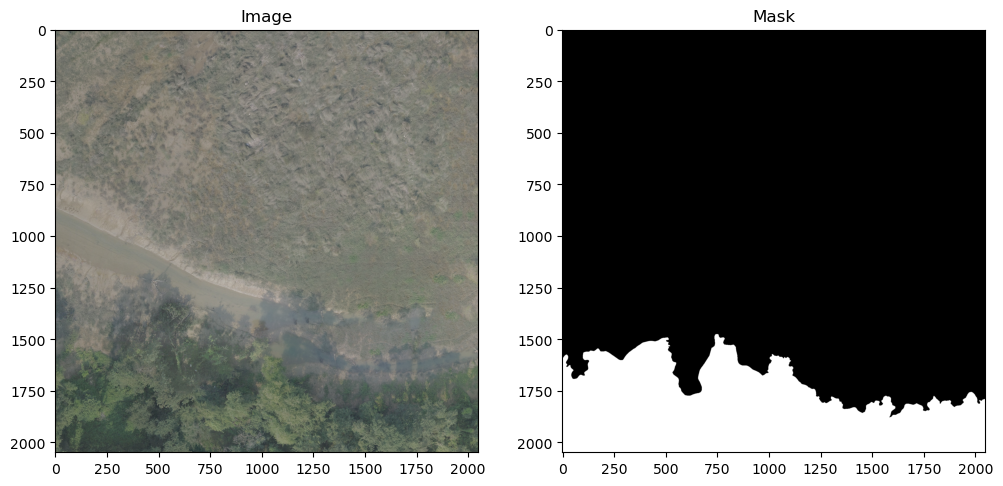

In [55]:
no_of_images_to_show = 3  # Number of images to show from the batch

images, masks = data_generator.__next__()  # Get the batch of images and masks

if no_of_images_to_show > batch_size:
    no_of_images_to_show = batch_size

for i in range(0, no_of_images_to_show):
    image = images[i].permute(1, 2, 0).numpy()  # Access individual image and convert to numpy array
    mask = masks[i].squeeze().numpy()  # Access individual mask and convert to numpy array
    visualize(image, mask)

## Model training

In [5]:
pan_model = PAN(in_channels)
train_model(pan_model, data_generator)

Epoch 1/10, Loss: 0.6932
Epoch 2/10, Loss: 0.6931
Epoch 3/10, Loss: 0.6931
Epoch 4/10, Loss: 0.6931
Epoch 5/10, Loss: 0.6931
Epoch 6/10, Loss: 0.6931


KeyboardInterrupt: 

### Yolo V8 Data Preparation

In [8]:
import numpy as np
import cv2
from shapely.geometry import Polygon
import tifffile


def mask_to_polygons(img_path, mask_path):
    '''
    Convierte una máscara de imagen en polígonos. Devuelve dos listas:
    - Lista de polígonos de shapely sin normalizar
    - Lista de polígonos de shapely normalizados (coordenadas entre 0 y 1)

    Args:
        img_path (str): Ruta al archivo de imagen original.
        mask_path (str): Ruta al archivo de la máscara en escala de grises.
    '''

    mask = tifffile.imread(mask_path)

    # mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Calcula los contornos 
    mask = mask.astype(bool)
    #contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # convertimos los contornos a polígonos de Label Studio
    polygons = []
    normalized_polygons = []
    for contour in contours:

        # Lo meto en un try porque la extraccion de polígonos que hace el opencv a partir de la máscara
        # a veces genera polígonos de menos de 4 vértices, que no tiene sentido por no ser cerrados, 
        # provocando que falle al convertir a polígno de shapely

        try:
            polygon = contour.reshape(-1, 2).tolist()

            # normalizamos las coordenadas entre 0 y 1 porque así lo requiere YOLOv8
            normalized_polygon = [[round(coord[0] / mask.shape[1], 4), round(coord[1] / mask.shape[0], 4)] for coord in
                                  polygon]

            # Convertimos a objeto poligono de shapely (sin normalizar)
            polygon_shapely = Polygon(polygon)
            simplified_polygon = polygon_shapely.simplify(0.85, preserve_topology=True)
            polygons.append(simplified_polygon)

            # normalizdos
            normalized_polygons.append(Polygon(normalized_polygon))


        except Exception as e:
            pass

    return polygons, normalized_polygons

In [25]:
def mask_to_polygons_per_class(img_path, mask_path):
    # Map grayscale mask values to your class indices
    class_mapping = {0: 0, 1: 1, 2: 2}

    mask = tifffile.imread(mask_path)

    polygons_per_class = {}
    for mask_value in np.unique(mask):
        # Look up class index using mask value, if no mapping is found then continue
        class_index = class_mapping.get(mask_value)
        if class_index is None:
            continue

        class_mask = np.where(mask == mask_value, 1, 0).astype(np.uint8)

        contours, _ = cv2.findContours(class_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        polygons = []
        for contour in contours:
            try:
                polygon = contour.reshape(-1, 2).tolist()

                normalized_polygon = [
                    [round(coord[0] / mask.shape[1], 4), round(coord[1] / mask.shape[0], 4)]
                    for coord in polygon
                ]

                if class_index not in polygons_per_class:
                    polygons_per_class[class_index] = []
                polygons_per_class[class_index].append(Polygon(normalized_polygon))

            except Exception as e:
                pass

    return polygons_per_class


In [21]:
import os
import cv2

input_dir = os.path.join(patch_output_dir, 'masks')
output_dir = labels_output_dir

for j in os.listdir(input_dir):
    image_path = os.path.join(input_dir, j)
    polygons, normalized_polygons = mask_to_polygons(image_path, image_path)  # Separate lists for each class

    # print the polygons
    file_name_without_ext = os.path.splitext(j)[0]
    if file_name_without_ext.endswith('_mask'):
        file_name_without_ext = file_name_without_ext[:-5]

    with open('{}.txt'.format(os.path.join(output_dir, file_name_without_ext)), 'w') as f:
        for class_label in range(3):
            for polygon in normalized_polygons:
                f.write('{} '.format(class_label))  # Add class label at the beginning of each line
                if isinstance(polygon, Polygon):
                    x, y = polygon.exterior.xy
                    for i in range(len(x)):
                        f.write('{} {}\t'.format(x[i], y[i]))
                f.write('\n')


In [29]:
import os
import cv2

input_dir = os.path.join(patch_output_dir, 'masks')
output_dir = labels_output_dir


for j in os.listdir(input_dir):
    image_path = os.path.join(input_dir, j)
    polygons_per_class = mask_to_polygons_per_class(image_path, image_path)

    # print the polygons
    file_name_without_ext = os.path.splitext(j)[0]
    if file_name_without_ext.endswith('_mask'):
        file_name_without_ext = file_name_without_ext[:-5]
    
    with open('{}.txt'.format(os.path.join(output_dir, file_name_without_ext)), 'w') as f:
        for class_label, polygons in polygons_per_class.items():
            for polygon in polygons:
                f.write('{} '.format(class_label))  # Add class label at the beginning of each line
                x, y = polygon.exterior.xy
                for i in range(len(x)):
                    f.write('{} {}\t'.format(x[i], y[i]))
                f.write('\n')

### Split the dataset into train, validation, and test sets

In [30]:
import os
import shutil
import numpy as np


def split_dataset_into_train_val_test(input_folder, output_folder, ratio=(0.7, 0.15, 0.15)):
    assert sum(ratio) == 1, "Ratios must add up to 1."

    # Get all file names in the input folder
    all_files = os.listdir(input_folder)
    np.random.shuffle(all_files)

    num_files = len(all_files)
    train_files = all_files[:int(num_files * ratio[0])]
    val_files = all_files[int(num_files * ratio[0]):int(num_files * (ratio[0] + ratio[1]))]
    test_files = all_files[int(num_files * (ratio[0] + ratio[1])):]

    # Create output directories
    for dir in ['train', 'val', 'test']:
        os.makedirs(os.path.join(output_folder, dir), exist_ok=True)

    # Move files to respective directories
    for file in train_files:
        shutil.move(os.path.join(input_folder, file), os.path.join(output_folder, 'train', file))

    for file in val_files:
        shutil.move(os.path.join(input_folder, file), os.path.join(output_folder, 'val', file))

    for file in test_files:
        shutil.move(os.path.join(input_folder, file), os.path.join(output_folder, 'test', file))


directories = ['images', 'labels', 'masks']
patch_output_directory = patch_output_dir

for directory in directories:
    input_folder = os.path.join(patch_output_directory, directory)
    output_folder = os.path.join(patch_output_directory, directory)
    split_dataset_into_train_val_test(input_folder, output_folder)

### Merge all files in the subfolders to the main folder

In [ ]:
import shutil
import os


def merge_all_files(directory):
    main_folders = ['images', 'labels', 'masks']
    subfolders = ['test', 'train', 'val']

    for main_folder in main_folders:
        main_folder_path = os.path.join(directory, main_folder)

        for subfolder in subfolders:
            subfolder_path = os.path.join(main_folder_path, subfolder)

            # merge all files in subfolder to main_folder
            for filename in os.listdir(subfolder_path):
                shutil.move(os.path.join(subfolder_path, filename), main_folder_path)

            # remove subfolder
            shutil.rmtree(subfolder_path)
# function call
merge_all_files(patch_output_dir)

In [3]:
from ultralytics import YOLO

model = YOLO('yolov8m-seg.pt')

model.train(data='config.yaml', epochs=100, imgsz=512, single_cls=False)

New https://pypi.org/project/ultralytics/8.1.25 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.20 🚀 Python-3.11.8 torch-2.2.1+cu121 CUDA:0 (NVIDIA GeForce RTX 2060, 5927MiB)
engine/trainer: task=segment, mode=train, model=yolov8m-seg.pt, data=config.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=512, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train13, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, s

2024-03-10 00:09:42.193100: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-10 00:09:42.193127: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-10 00:09:42.194111: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics

train: Scanning /media/D-Drive/M Tech AI/Thesis/Projects/Sattellite Segmentation Nepal/output/512x512/labels/train.cache... 1037 images, 446 backgrounds, 0 corrupt: 100%|██████████| 1483/1483 [00:00<?, ?it/s]
val: Scanning /media/D-Drive/M Tech AI/Thesis/Projects/Sattellite Segmentation Nepal/output/512x512/labels/val.cache... 56 images, 262 backgrounds, 0 corrupt: 100%|██████████| 318/318 [00:00<?, ?it/s]


Plotting labels to runs/segment/train13/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 512 train, 512 val
Using 8 dataloader workers
Logging results to runs/segment/train13
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      1/100      5.37G      1.153      2.985      2.093      1.478         53        512: 100%|██████████| 93/93 [00:46<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.90it/s]

                   all        318        217     0.0763      0.258     0.0454     0.0221     0.0719      0.241     0.0401     0.0176



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      2/100      5.58G      1.268      2.691      1.887      1.542         57        512: 100%|██████████| 93/93 [00:43<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.30it/s]

                   all        318        217     0.0418      0.144     0.0186    0.00804     0.0315      0.121     0.0154    0.00536



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      3/100      5.62G      1.293      2.691      1.849      1.551         34        512: 100%|██████████| 93/93 [00:45<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.08it/s]

                   all        318        217     0.0708      0.236     0.0363     0.0175     0.0617       0.24     0.0365     0.0173



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      4/100      5.68G      1.246      2.608      1.788      1.533         41        512: 100%|██████████| 93/93 [00:46<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.80it/s]

                   all        318        217     0.0767      0.279     0.0566     0.0291     0.0743      0.265     0.0523     0.0261



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      5/100      5.58G      1.162      2.495      1.667      1.467         65        512: 100%|██████████| 93/93 [00:46<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.56it/s]

                   all        318        217      0.102      0.281     0.0606     0.0327      0.107      0.267     0.0596     0.0316



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      6/100      5.62G      1.163      2.464      1.643      1.467         50        512: 100%|██████████| 93/93 [00:43<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.27it/s]

                   all        318        217      0.104      0.366       0.08     0.0553      0.105      0.368       0.08     0.0479



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      7/100      5.66G      1.113      2.409      1.616      1.432         67        512: 100%|██████████| 93/93 [00:45<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.31it/s]

                   all        318        217     0.0968      0.362     0.0655     0.0392     0.0903      0.347      0.061     0.0334



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      8/100      5.62G      1.098      2.312      1.544      1.421         43        512: 100%|██████████| 93/93 [00:45<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.33it/s]

                   all        318        217      0.136      0.376     0.0961     0.0631      0.139      0.377      0.096     0.0597



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      9/100       5.6G      1.053      2.293      1.507      1.389         56        512: 100%|██████████| 93/93 [00:45<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.28it/s]

                   all        318        217      0.138       0.39     0.0953     0.0642      0.128      0.384     0.0928     0.0591



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     10/100      5.68G      1.056      2.162      1.484        1.4         46        512: 100%|██████████| 93/93 [00:46<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.81it/s]

                   all        318        217      0.114      0.389     0.0977     0.0703      0.114       0.39     0.0975      0.065



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     11/100      5.63G      1.047      2.126      1.476      1.398         55        512: 100%|██████████| 93/93 [00:44<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.33it/s]

                   all        318        217      0.125      0.418     0.0908     0.0584      0.125      0.416     0.0895     0.0548



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     12/100      5.62G      1.054      2.212      1.483      1.397         49        512: 100%|██████████| 93/93 [00:46<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.76it/s]

                   all        318        217      0.131      0.421     0.0891     0.0653      0.133      0.378      0.085     0.0542



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     13/100      5.65G       1.01      2.088      1.424      1.363         46        512: 100%|██████████| 93/93 [00:46<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.27it/s]

                   all        318        217      0.121      0.446     0.0998     0.0708       0.13      0.425     0.0968     0.0626



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     14/100       5.6G      1.029      2.138      1.466      1.376         35        512: 100%|██████████| 93/93 [00:46<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.24it/s]

                   all        318        217       0.13      0.413     0.0959      0.071      0.125      0.403     0.0944     0.0666



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     15/100      5.61G      1.009      2.038      1.402      1.365         39        512: 100%|██████████| 93/93 [00:45<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.41it/s]

                   all        318        217      0.126      0.452      0.102     0.0744      0.156      0.383      0.104     0.0706



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     16/100      5.63G     0.9854      2.029      1.413      1.346         51        512: 100%|██████████| 93/93 [00:45<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.25it/s]

                   all        318        217      0.114      0.444     0.0911     0.0597      0.114      0.444     0.0931     0.0546



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     17/100      5.61G     0.9927      2.032      1.397      1.357         54        512: 100%|██████████| 93/93 [00:46<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]

                   all        318        217      0.152      0.455      0.117      0.079      0.148      0.435      0.114      0.074



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     18/100      5.58G     0.9843      2.027      1.374      1.345         39        512: 100%|██████████| 93/93 [00:47<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.78it/s]

                   all        318        217      0.171      0.449      0.128     0.0944      0.171      0.449      0.127     0.0887



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     19/100      5.61G     0.9582      1.957      1.376      1.328         41        512: 100%|██████████| 93/93 [00:45<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.31it/s]

                   all        318        217       0.15      0.508      0.137     0.0942      0.157      0.489      0.136     0.0887



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     20/100      5.59G     0.9529       2.01      1.348      1.332         58        512: 100%|██████████| 93/93 [00:46<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.31it/s]

                   all        318        217      0.142      0.404      0.119     0.0857       0.14      0.403      0.111     0.0713



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     21/100      5.62G     0.9472      1.936      1.341      1.321         29        512: 100%|██████████| 93/93 [00:46<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.29it/s]

                   all        318        217      0.146      0.472      0.116     0.0856      0.145       0.51      0.121     0.0786



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     22/100      5.57G     0.9461       1.88      1.323       1.32         49        512: 100%|██████████| 93/93 [00:46<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.21it/s]

                   all        318        217      0.146       0.41      0.122     0.0884      0.152      0.421      0.123     0.0799



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     23/100      5.64G     0.9499      1.875       1.34       1.32         31        512: 100%|██████████| 93/93 [00:46<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.27it/s]

                   all        318        217      0.182      0.401      0.131     0.0952      0.179      0.378      0.127     0.0858



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     24/100       5.6G     0.9311      1.897      1.298       1.31         30        512: 100%|██████████| 93/93 [00:46<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.34it/s]

                   all        318        217      0.173      0.501      0.147      0.104      0.173      0.496      0.146     0.0942



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     25/100      5.56G     0.9366      1.828      1.274      1.311         65        512: 100%|██████████| 93/93 [00:46<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.35it/s]

                   all        318        217      0.141      0.463      0.129     0.0976      0.147       0.46      0.131     0.0889



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     26/100      5.61G     0.9062      1.852      1.277      1.295         43        512: 100%|██████████| 93/93 [00:46<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.31it/s]

                   all        318        217      0.175      0.543       0.16      0.119      0.174      0.542      0.158      0.107



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     27/100      5.61G      0.919      1.834      1.275      1.299         41        512: 100%|██████████| 93/93 [00:46<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.28it/s]

                   all        318        217      0.144      0.477       0.13     0.0915      0.148      0.471      0.127     0.0844



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     28/100      5.61G      0.911      1.832      1.279      1.299         57        512: 100%|██████████| 93/93 [00:46<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.23it/s]

                   all        318        217      0.159       0.55      0.143      0.107      0.159      0.549      0.138     0.0983



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     29/100      5.59G      0.899      1.753       1.23      1.284         32        512: 100%|██████████| 93/93 [00:46<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.28it/s]

                   all        318        217      0.179      0.543       0.16      0.116      0.175      0.528      0.156      0.108



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     30/100      5.59G     0.8928      1.741       1.26      1.276         45        512: 100%|██████████| 93/93 [00:44<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.41it/s]

                   all        318        217      0.174      0.501       0.15      0.114      0.169      0.493      0.145      0.104



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     31/100      5.65G     0.8759      1.729      1.215       1.26         51        512: 100%|██████████| 93/93 [00:45<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.28it/s]

                   all        318        217      0.175      0.566      0.152      0.114      0.174      0.494      0.146     0.0988



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     32/100      5.64G     0.8752       1.71      1.222      1.267         66        512: 100%|██████████| 93/93 [00:45<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.22it/s]

                   all        318        217      0.173      0.579      0.153      0.114      0.175      0.575      0.151      0.104



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     33/100       5.6G     0.8716      1.732      1.209      1.267         50        512: 100%|██████████| 93/93 [00:47<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.30it/s]

                   all        318        217      0.173      0.526       0.16      0.121       0.17      0.502      0.156      0.107



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     34/100      5.65G     0.8784      1.702      1.213      1.269         60        512: 100%|██████████| 93/93 [00:46<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.24it/s]

                   all        318        217      0.186       0.45      0.157      0.119      0.188      0.453       0.16      0.101



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     35/100       5.6G     0.8856      1.675       1.23      1.279         60        512: 100%|██████████| 93/93 [00:45<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.34it/s]

                   all        318        217       0.17      0.566      0.157      0.118      0.166      0.564      0.157      0.103



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     36/100      5.63G     0.8676      1.683      1.205       1.26         45        512: 100%|██████████| 93/93 [00:45<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.33it/s]

                   all        318        217      0.172      0.493      0.147      0.114      0.172       0.49      0.147      0.101



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     37/100      5.58G     0.8573      1.662      1.165      1.258         52        512: 100%|██████████| 93/93 [00:45<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.30it/s]

                   all        318        217      0.183      0.623      0.156      0.123      0.178      0.602      0.155      0.112



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     38/100      5.58G     0.8574      1.704      1.191      1.254         59        512: 100%|██████████| 93/93 [00:45<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.41it/s]

                   all        318        217      0.181       0.49      0.141      0.107      0.184      0.495      0.138     0.0982



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     39/100      5.63G     0.8477      1.692      1.185      1.245         43        512: 100%|██████████| 93/93 [00:45<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.20it/s]

                   all        318        217      0.158      0.487       0.14     0.0999      0.164      0.501      0.142     0.0917



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     40/100       5.6G     0.8439      1.635      1.183      1.245         47        512: 100%|██████████| 93/93 [00:46<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.27it/s]

                   all        318        217      0.165      0.544      0.141      0.103      0.167      0.534      0.137     0.0926



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     41/100      5.58G     0.8221      1.607      1.191      1.228         48        512: 100%|██████████| 93/93 [00:46<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.37it/s]

                   all        318        217      0.166      0.589      0.161       0.12      0.172      0.582      0.169       0.11



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     42/100      5.65G      0.826      1.645      1.166      1.236         43        512: 100%|██████████| 93/93 [00:45<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.27it/s]

                   all        318        217      0.183      0.548      0.158      0.122      0.187      0.563      0.159       0.11



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     43/100      5.63G     0.8143      1.572      1.141      1.223         43        512: 100%|██████████| 93/93 [00:47<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.23it/s]

                   all        318        217      0.178      0.536      0.172       0.12      0.175      0.537      0.169      0.113



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     44/100      5.63G     0.8345       1.63      1.173       1.25         54        512: 100%|██████████| 93/93 [00:47<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.62it/s]

                   all        318        217       0.19       0.53       0.18      0.141      0.192      0.534      0.179      0.122



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     45/100       5.6G     0.8181      1.545       1.14      1.224         55        512: 100%|██████████| 93/93 [00:45<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]

                   all        318        217      0.184      0.559       0.18      0.139       0.18      0.514      0.174      0.123



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     46/100      5.57G     0.8163      1.513      1.113      1.227         46        512: 100%|██████████| 93/93 [00:46<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.32it/s]

                   all        318        217      0.188      0.587      0.172      0.133      0.189      0.592      0.174       0.12



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     47/100      5.66G     0.8057      1.537      1.113      1.217         61        512: 100%|██████████| 93/93 [00:47<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.34it/s]

                   all        318        217      0.171      0.558      0.172      0.132      0.167      0.538      0.169       0.12



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     48/100      5.65G      0.798       1.47      1.097      1.212         55        512: 100%|██████████| 93/93 [00:47<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.24it/s]

                   all        318        217      0.182      0.529      0.151      0.121      0.186      0.539      0.152      0.111



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     49/100      5.57G     0.7973      1.487      1.115      1.214         37        512: 100%|██████████| 93/93 [00:45<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.40it/s]

                   all        318        217       0.18      0.593      0.166      0.126      0.177       0.55      0.165      0.113



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     50/100      5.59G     0.8182      1.524      1.117      1.225         37        512: 100%|██████████| 93/93 [00:45<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.31it/s]

                   all        318        217      0.192      0.518      0.179      0.139      0.193      0.523      0.181      0.127



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     51/100      5.61G     0.7896      1.485      1.094      1.212         43        512: 100%|██████████| 93/93 [00:44<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.37it/s]

                   all        318        217      0.194       0.58      0.206      0.161      0.192      0.585      0.207      0.144



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     52/100      5.64G      0.817      1.526      1.147      1.233         36        512: 100%|██████████| 93/93 [00:44<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.35it/s]

                   all        318        217       0.19      0.589      0.181      0.135      0.186      0.575      0.177      0.117



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     53/100      5.59G     0.7977      1.429      1.098       1.21         60        512: 100%|██████████| 93/93 [00:44<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.29it/s]

                   all        318        217      0.185      0.544      0.188      0.143      0.182      0.536      0.183      0.129



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     54/100      5.56G     0.7929      1.452      1.086      1.203         48        512: 100%|██████████| 93/93 [00:44<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.28it/s]

                   all        318        217      0.193      0.658      0.196      0.157      0.189      0.645      0.194      0.135



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     55/100       5.6G     0.7855      1.445      1.088      1.202         50        512: 100%|██████████| 93/93 [00:44<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.37it/s]

                   all        318        217      0.186      0.522      0.182      0.147      0.186      0.522      0.181      0.129



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     56/100      5.61G     0.8024      1.472      1.097      1.209         44        512: 100%|██████████| 93/93 [00:45<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.41it/s]

                   all        318        217      0.198       0.56        0.2       0.15      0.197      0.564        0.2       0.14



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     57/100      5.59G     0.7619      1.359      1.042      1.189         56        512: 100%|██████████| 93/93 [00:44<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.34it/s]

                   all        318        217      0.181      0.575      0.171      0.139      0.185      0.584      0.173      0.124



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     58/100       5.6G     0.7868      1.404      1.069       1.21         44        512: 100%|██████████| 93/93 [00:44<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.35it/s]

                   all        318        217      0.181      0.604      0.178       0.14      0.181      0.604      0.179      0.131



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     59/100      5.65G     0.7608      1.397       1.05       1.18         54        512: 100%|██████████| 93/93 [00:45<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.30it/s]

                   all        318        217      0.186      0.611      0.198      0.154       0.18      0.598      0.192      0.135



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     60/100      5.63G     0.7644      1.407      1.067      1.183         27        512: 100%|██████████| 93/93 [00:45<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.40it/s]

                   all        318        217      0.194      0.526       0.19       0.15      0.201      0.546      0.194      0.137



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     61/100       5.6G     0.7539      1.367      1.046      1.183         56        512: 100%|██████████| 93/93 [00:45<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.39it/s]

                   all        318        217      0.199      0.574      0.195      0.153      0.202      0.594        0.2      0.142



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     62/100       5.6G     0.7538      1.336      1.031      1.178         34        512: 100%|██████████| 93/93 [00:45<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.42it/s]

                   all        318        217      0.185      0.614      0.191      0.152      0.195      0.551      0.196      0.138



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     63/100      5.69G     0.7298      1.306      1.014      1.159         45        512: 100%|██████████| 93/93 [00:44<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.38it/s]

                   all        318        217       0.19       0.61      0.192      0.157      0.191      0.615      0.193      0.145



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     64/100      5.64G     0.7473      1.376      1.031      1.181         38        512: 100%|██████████| 93/93 [00:45<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.34it/s]

                   all        318        217      0.185       0.63      0.191      0.154      0.187      0.654      0.195      0.141



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     65/100       5.6G      0.752      1.352       1.03      1.193         36        512: 100%|██████████| 93/93 [00:45<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.39it/s]

                   all        318        217      0.202      0.642      0.196      0.162      0.199      0.637      0.195      0.142



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     66/100      5.57G      0.733      1.294      1.026      1.172         32        512: 100%|██████████| 93/93 [00:44<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.39it/s]

                   all        318        217      0.201      0.625      0.197      0.163      0.197      0.609      0.195      0.142



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     67/100      5.62G     0.7391      1.315      1.019      1.169         47        512: 100%|██████████| 93/93 [00:44<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.37it/s]

                   all        318        217      0.189      0.545      0.169       0.14      0.188      0.578      0.169      0.126



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     68/100      5.62G      0.721      1.258     0.9841      1.162         49        512: 100%|██████████| 93/93 [00:45<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.38it/s]

                   all        318        217      0.201      0.646      0.203      0.167      0.199      0.638      0.202      0.152



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     69/100      5.61G     0.7211      1.297     0.9903      1.154         59        512: 100%|██████████| 93/93 [00:44<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.42it/s]

                   all        318        217      0.193       0.67      0.194       0.16      0.192      0.635      0.193      0.147



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     70/100      5.58G     0.7329      1.238      1.009      1.163         47        512: 100%|██████████| 93/93 [00:44<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.42it/s]

                   all        318        217      0.196      0.704      0.192      0.155      0.192      0.687      0.186      0.136



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     71/100       5.6G     0.7363       1.21     0.9893       1.17         60        512: 100%|██████████| 93/93 [00:44<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.33it/s]

                   all        318        217      0.199      0.666      0.211      0.171      0.193      0.711      0.202      0.148



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     72/100      5.61G     0.7291      1.277      1.014      1.157         44        512: 100%|██████████| 93/93 [00:44<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.42it/s]

                   all        318        217      0.199      0.641      0.185      0.154      0.194      0.648      0.183      0.137



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     73/100      5.61G     0.7151      1.227     0.9692      1.164         41        512: 100%|██████████| 93/93 [00:44<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.43it/s]

                   all        318        217      0.188      0.698      0.186      0.149      0.187      0.695      0.187      0.139



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     74/100      5.62G     0.7093      1.201     0.9599      1.145         51        512: 100%|██████████| 93/93 [00:44<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.41it/s]

                   all        318        217      0.191      0.665      0.193       0.16      0.189      0.679      0.195      0.144



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     75/100      5.63G     0.6987       1.18     0.9463      1.148         47        512: 100%|██████████| 93/93 [00:45<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.35it/s]

                   all        318        217      0.197      0.655      0.213      0.175      0.194      0.646      0.207      0.155



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     76/100       5.6G     0.6896      1.185     0.9553      1.137         52        512: 100%|██████████| 93/93 [00:44<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.41it/s]

                   all        318        217      0.202      0.682      0.208      0.166      0.205      0.691      0.202       0.15



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     77/100      5.57G     0.6894      1.172     0.9582      1.139         58        512: 100%|██████████| 93/93 [00:44<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.41it/s]

                   all        318        217        0.2      0.709      0.204      0.166      0.199      0.704      0.202      0.151



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     78/100       5.6G     0.6968      1.159     0.9633      1.144         42        512: 100%|██████████| 93/93 [00:44<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.40it/s]

                   all        318        217      0.197      0.675        0.2      0.168      0.193      0.686        0.2      0.152



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     79/100      5.62G     0.6793      1.158      0.937       1.13         34        512: 100%|██████████| 93/93 [00:44<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.36it/s]

                   all        318        217      0.192      0.607      0.196      0.166       0.19      0.602      0.195      0.147



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     80/100      5.66G     0.6908      1.156     0.9549      1.138         46        512: 100%|██████████| 93/93 [00:44<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.45it/s]

                   all        318        217      0.195       0.69      0.211      0.174      0.197      0.618      0.209       0.16



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     81/100      5.58G     0.6815      1.103     0.9288      1.132         43        512: 100%|██████████| 93/93 [00:44<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.33it/s]

                   all        318        217      0.194      0.654       0.22      0.179      0.193      0.627      0.216      0.162



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     82/100       5.6G     0.6633      1.105     0.9231      1.117         58        512: 100%|██████████| 93/93 [00:44<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.37it/s]

                   all        318        217      0.202      0.699      0.212      0.177        0.2      0.692       0.21      0.156



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     83/100      5.62G     0.6817      1.121     0.9141      1.132         47        512: 100%|██████████| 93/93 [00:44<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.37it/s]

                   all        318        217      0.197      0.669      0.195      0.166      0.196      0.689      0.195      0.149



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     84/100      5.62G     0.6738      1.148     0.9481      1.134         52        512: 100%|██████████| 93/93 [00:44<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.37it/s]

                   all        318        217      0.206       0.64      0.216      0.176      0.206       0.64      0.209      0.161



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     85/100      5.59G     0.6544      1.112      0.933      1.125         59        512: 100%|██████████| 93/93 [00:44<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.40it/s]

                   all        318        217      0.198       0.68      0.226      0.182      0.201      0.689      0.228      0.165



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     86/100      5.56G     0.6521      1.039     0.9198      1.119         38        512: 100%|██████████| 93/93 [00:44<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.41it/s]

                   all        318        217      0.203      0.665       0.21      0.172      0.202      0.666      0.212      0.158



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     87/100      5.62G     0.6741      1.087      0.929      1.124         46        512: 100%|██████████| 93/93 [00:44<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.39it/s]

                   all        318        217      0.208      0.668      0.231      0.195      0.205      0.651       0.23      0.174



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     88/100      5.67G     0.6655      1.079     0.9172      1.123         43        512: 100%|██████████| 93/93 [00:44<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.39it/s]

                   all        318        217      0.217       0.54      0.235      0.198      0.215      0.535      0.233      0.172



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     89/100      5.59G     0.6588      1.121     0.9235       1.12         48        512: 100%|██████████| 93/93 [00:44<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.38it/s]

                   all        318        217      0.203      0.605      0.202       0.17      0.203      0.605      0.203       0.15



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     90/100      5.56G     0.6674      1.016     0.8954      1.123         51        512: 100%|██████████| 93/93 [00:44<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.38it/s]

                   all        318        217      0.198      0.599      0.221      0.186      0.202      0.617      0.223      0.163


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     91/100      5.61G     0.5183      1.502       1.02      1.045         13        512: 100%|██████████| 93/93 [00:44<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.36it/s]

                   all        318        217      0.196      0.601      0.199      0.169      0.194      0.641      0.199      0.152



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     92/100       5.6G     0.4763      1.403     0.9159      1.026         11        512: 100%|██████████| 93/93 [00:43<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.43it/s]

                   all        318        217      0.197      0.653      0.208      0.179      0.197      0.636      0.205      0.153



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     93/100      5.56G     0.4507      1.299     0.8353     0.9985         12        512: 100%|██████████| 93/93 [00:43<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.30it/s]

                   all        318        217      0.206       0.69        0.2      0.167        0.2      0.654      0.198      0.154



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     94/100      5.57G     0.4742      1.285     0.8484      1.022         17        512: 100%|██████████| 93/93 [00:43<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.45it/s]

                   all        318        217      0.203      0.647      0.211      0.175      0.203      0.598       0.21      0.158



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     95/100      5.61G     0.4528      1.227     0.8349     0.9971         20        512: 100%|██████████| 93/93 [00:43<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.40it/s]

                   all        318        217      0.196      0.667      0.205      0.172      0.197      0.648      0.206      0.154



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     96/100       5.6G     0.4593      1.237     0.8131       1.01         19        512: 100%|██████████| 93/93 [00:43<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.43it/s]

                   all        318        217      0.195      0.637      0.204       0.17      0.192      0.627      0.203      0.154



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     97/100      5.56G     0.4537      1.246     0.8379      1.008         22        512: 100%|██████████| 93/93 [00:44<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.37it/s]

                   all        318        217      0.205       0.65      0.215      0.178      0.204      0.639      0.212      0.159



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     98/100      5.57G     0.4427      1.246     0.8103      1.002         15        512: 100%|██████████| 93/93 [00:43<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.43it/s]

                   all        318        217      0.211      0.642      0.211      0.178      0.207      0.631      0.205      0.159



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     99/100       5.6G     0.4463      1.327      0.805     0.9983         20        512: 100%|██████████| 93/93 [00:43<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.40it/s]

                   all        318        217      0.213      0.659      0.211      0.182      0.211      0.654      0.209      0.162



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    100/100      5.59G     0.4229      1.197     0.7931     0.9763         21        512: 100%|██████████| 93/93 [00:43<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.43it/s]

                   all        318        217      0.214      0.644      0.206      0.176      0.211      0.623        0.2      0.156



100 epochs completed in 1.485 hours.
Optimizer stripped from runs/segment/train13/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train13/weights/best.pt, 54.8MB

Validating runs/segment/train13/weights/best.pt...
Ultralytics YOLOv8.1.20 🚀 Python-3.11.8 torch-2.2.1+cu121 CUDA:0 (NVIDIA GeForce RTX 2060, 5927MiB)
YOLOv8m-seg summary (fused): 245 layers, 27224121 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.02it/s]


                   all        318        217      0.217      0.538      0.233      0.197      0.215      0.533      0.231      0.171
            background        318         86       0.22      0.558       0.21      0.176       0.22      0.558      0.213      0.161
              building        318         64      0.231      0.578      0.266      0.235      0.231      0.578      0.268      0.204
              woodland        318         67      0.201      0.478      0.223      0.179      0.194      0.463      0.213      0.149
Speed: 0.1ms preprocess, 9.3ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/segment/train13


ultralytics.utils.metrics.SegmentMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7011b319b7d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(M)', 'F1-Confidence(M)', 'Precision-Confidence(M)', 'Recall-Confidence(M)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.04

In [5]:
import cv2
from ultralytics import YOLO

model_path = 'runs/segment/train13/weights/best.pt'

image_path = 'output/2048x2048/images/patch_598.tiff'

img= cv2.imread(image_path)
H, W, _ = img.shape

model = YOLO(model_path)

results = model(img)

# Process results list
for result in results:
    boxes = result.boxes  # Boxes object for bounding box outputs
    masks = result.masks  # Masks object for segmentation masks outputs
    keypoints = result.keypoints  # Keypoints object for pose outputs
    probs = result.probs  # Probs object for classification outputs
    result.show()  # display to screen
    result.save(filename='result.jpg')  # save to disk
# 
# for result in results:
#     for j,mask in enumerate(result.masks.data):
#         mask=mask.cpu().numpy()*255
#         mask=cv2.resize(mask, (W,H))
#         visualize(img,mask)
#         print(f"Class of mask {j}: {result.masks.data.names[j]}")

0: 512x512 8 buildings, 39.0ms
Speed: 4.0ms preprocess, 39.0ms inference, 21.5ms postprocess per image at shape (1, 3, 512, 512)


In [22]:

mask_path = './output/512x512/masks/test/patch_3361_mask.jpg'
mask = tifffile.imread(mask_path)
unique_values = np.unique(mask)
print(unique_values)


[          0           1]
